In [1]:
import numpy as np
import argparse
import os
import sys
import torch
import torch.fft as F
from importlib import reload
from torch.nn.functional import relu
import torch.nn as nn
import torch.nn.functional as Func
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pdb
from utils import *
from mnet import MNet
import unet_train
from unet_train import mnet_getinput

In [2]:
sys.path.insert(0,'/home/huangz78/mri/unet/')
import unet_model
reload(unet_model)
from unet_model import UNet

In [50]:
histpath = '/mnt/shared_a/checkpoints/TrainRec_unet_1_True_8fmnet_epoch_39.npz'
hist = np.load(histpath)
print(hist.files)

['trainloss', 'testloss', 'trainloss_epoch']


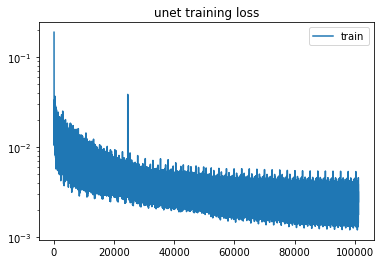

In [51]:
plt.figure()
plt.plot(hist['trainloss'],label='train')
plt.yscale('log')
plt.title('unet training loss')
plt.legend(loc='best')
plt.show()

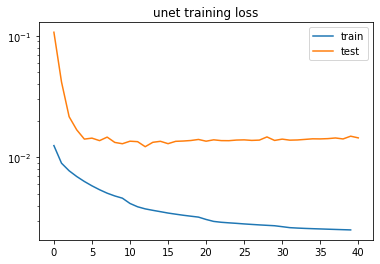

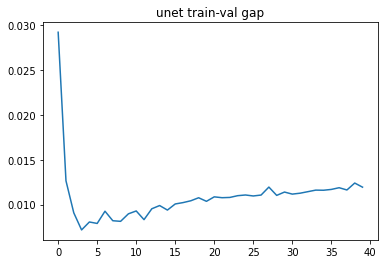

In [52]:
plt.figure()
plt.plot(hist['trainloss_epoch'],label='train')
plt.plot(hist['testloss'],label='test')
plt.yscale('log')
plt.title('unet training loss')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.plot(hist['testloss'][1:] - hist['trainloss_epoch'])
plt.title('unet train-val gap')
plt.show()

## test mnet generating masks and preparing input for unet

In [5]:
reload(unet_train)
from unet_train import mnet_getinput

In [2]:
data= torch.tensor(np.load('/mnt/shared_a/data/fastMRI/knee_singlecoil_train.npz')['data'],dtype=torch.float)
print(data.shape)

torch.Size([12649, 320, 320])


In [3]:
mnet = MNet(beta=1,in_channels=2,out_size=320-8, imgsize=(320,320),poolk=3).to('cpu')
mnetpath = '/home/huangz78/checkpoints/mnet_split_trained_cf_8_bg_32_unet_in_chan_1.pt'
checkpoint = torch.load(mnetpath)
mnet.load_state_dict(checkpoint['model_state_dict'])
print('MNet loaded successfully from: ' + mnetpath)

MNet loaded successfully from: /home/huangz78/checkpoints/mnet_split_trained_cf_8_bg_32_unet_in_chan_1.pt


In [6]:
_,masks = mnet_getinput(mnet,data[0:1000],base=8,budget=32,batchsize=5,unet_channels=1,return_mask=True)

In [7]:
masks.shape

torch.Size([1000, 320])

In [8]:
for ind in range(1,1000):
    if (masks[ind,:]-masks[0,:]).abs().sum()!=0:
        print(ind)

## track errors

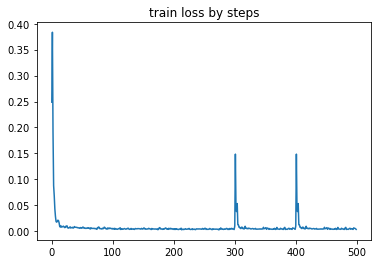

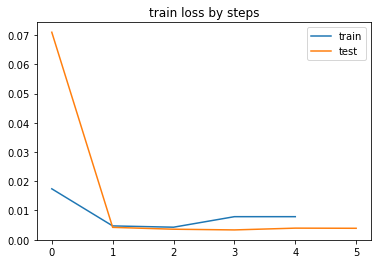

In [3]:
hist_path = '/home/huangz78/checkpoints/TrainRec_unet_1_False_8frand.npz'
hist = np.load(hist_path)
plt.figure()
plt.plot(hist['trainloss'])
plt.title('train loss by steps')
plt.show()

plt.figure()
plt.plot(hist['trainloss_epoch'],label='train')
plt.plot(hist['testloss'],label='test')
plt.title('train loss by steps')
plt.legend(loc='best')
plt.show()

## train test split

In [2]:
data_dir1 = '/home/huangz78/data/data_gt.npz'
data1 = np.load(data_dir1)
print('file1',data1.files)
print(data1['imgdata'].shape)
data_dir2 = '/mnt/shared_b/data/fastMRI/singlecoil_train/expanded_gt.npz'
data2 = np.load(data_dir2)
print('file2',data2.files)
print(data2['imgdata'].shape)

# data = np.concatenate((data1['imgdata'],data2['imgdata']),axis=2)
data = np.concatenate((data2['imgdata'],data1['imgdata']),axis=2)
del data1
del data2

file1 ['imgdata']
(320, 320, 199)
file2 ['imgdata']
(320, 320, 1014)


In [ ]:
from sklearn.model_selection import train_test_split
imgNum = 199+1014
traininds, testinds = train_test_split(np.arange(imgNum),random_state=0,shuffle=True,train_size=1000)

In [3]:
traininds = np.arange(0,1014,1)
testinds  = np.arange(1014,199+1014,1)

In [4]:
# trainimgs = data['imgdata'][:,:,traininds]
# testimgs = data['imgdata'][:,:,testinds]
dtyp = torch.float
Dtyp = torch.cfloat
trainimgs = data[:,:,traininds]
testimgs  = data[:,:,testinds]
train_y = torch.zeros((trainimgs.shape[2],trainimgs.shape[0],trainimgs.shape[1]),dtype=Dtyp)
train_yfull = torch.zeros((trainimgs.shape[2],trainimgs.shape[0],trainimgs.shape[1]),dtype=Dtyp)
train_x = torch.zeros((trainimgs.shape[2],trainimgs.shape[0],trainimgs.shape[1]),dtype=dtyp)
train_xfull = torch.zeros((trainimgs.shape[2],trainimgs.shape[0],trainimgs.shape[1]),dtype=dtyp)

test_y  = torch.zeros((testimgs.shape[2],testimgs.shape[0],testimgs.shape[1]),dtype=Dtyp)
test_yfull  = torch.zeros((testimgs.shape[2],testimgs.shape[0],testimgs.shape[1]),dtype=Dtyp)
test_x  = torch.zeros((testimgs.shape[2],testimgs.shape[0],testimgs.shape[1]),dtype=dtyp)
test_xfull  = torch.zeros((testimgs.shape[2],testimgs.shape[0],testimgs.shape[1]),dtype=dtyp)

In [5]:
import utils
from utils import mask_prob,mask_naiveRand
base = 0.075; other=0.15
torch.manual_seed(0)
mask = torch.tensor( mask_naiveRand(320,fix=round(320*base),other=round(320*other),roll=False)[0] ,dtype=dtyp )

/opt/anaconda/envs/pyenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

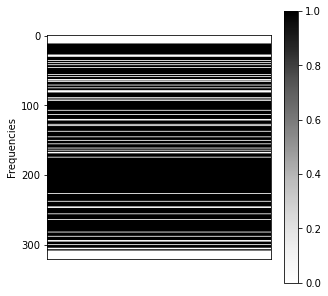

In [6]:
# mask = torch.fft.fftshift(mask)
print(mask)
kplot(mask)

In [7]:
for ind in range(trainimgs.shape[2]):
    img = trainimgs[:,:,ind]
    img = img/np.max(np.abs(img))
#     mask = torch.tensor( mask_prob(img,fix=round(320*base),other=round(320*other),roll=False) ,dtype=torch.double )
    train_xfull[ind,:,:] = torch.tensor(img)
    train_yfull[ind,:,:] = F.fftn(torch.tensor(img),dim=(0,1),norm='ortho')
    train_y[ind,:,:] = torch.tensordot(torch.diag(mask).to(Dtyp) , train_yfull[ind,:,:],dims=([1],[0]))
    train_x[ind,:,:] = torch.abs(F.ifftn(train_y[ind,:,:],dim=(0,1),norm='ortho'))
    
np.savez('/home/huangz78/data/traindata_y.npz',yfull=train_yfull,y=train_y,mask=mask)
np.savez('/home/huangz78/data/traindata_x.npz',xfull=train_xfull,x=train_x,mask=mask)

In [8]:
for ind in range(testimgs.shape[2]):
    img = testimgs[:,:,ind]
    img = img/np.max(np.abs(img))
#     mask = torch.tensor( mask_prob(img,fix=round(320*base),other=round(320*other),roll=False) ,dtype=torch.cdouble )
    test_xfull[ind,:,:] = torch.tensor(img)
    test_yfull[ind,:,:] = F.fftn(test_xfull[ind,:,:],dim=(0,1),norm='ortho')
    test_y[ind,:,:] = torch.tensordot(torch.diag(mask).to(Dtyp) , test_yfull[ind,:,:],dims=([1],[0]))
    test_x[ind,:,:] = torch.abs(F.ifftn(test_y[ind,:,:],dim=(0,1),norm='ortho'))
np.savez('/home/huangz78/data/testdata_y.npz',yfull=test_yfull,y=test_y,mask=mask)
np.savez('/home/huangz78/data/testdata_x.npz',xfull=test_xfull,x=test_x,mask=mask)

In [2]:
# check test data as an example
test_x_dir = '/home/huangz78/data/testdata_x.npz'
test_y_dir = '/home/huangz78/data/testdata_y.npz'
test_xfull = np.load(test_x_dir)['xfull']
test_yfull = np.load(test_y_dir)['yfull']
test_x = np.load(test_x_dir)['x']
test_y = np.load(test_y_dir)['y']
# kplot(test_xfull[0,:,:])
# kplot(test_x[0,:,:])
# kplot(test_yfull[0,:,:],roll=True,log=True)
# kplot(test_y[0,:,:],roll=True,log=True)

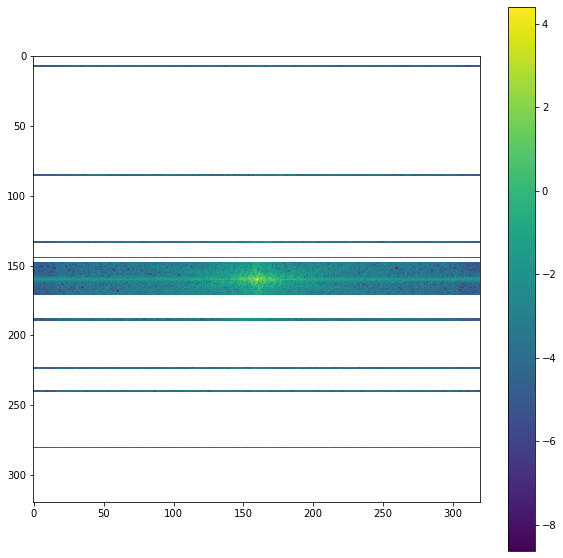

In [7]:
kplot(test_y[0,:,:],roll=True,log=True)

In [ ]:
train_data_dir = '/home/huangz78/data/traindata.npz'
train_y = np.load(train_data_dir)['y'][:,:,0:2]
train_yfull = np.load(train_data_dir)['yfull'][:,:,0:2]

train = np.load(train_data_dir)
print(train.files)

train['y'].dtype

## data view

In [8]:
train_dir = '/home/huangz78/data/traindata_x.npz'
train_sub = np.load(train_dir)['x'][0:2,:,:]
train_full = np.load(train_dir)['xfull'][0:2,:,:]

In [ ]:
np.load(train_dir)['xfull'].shape[0]

In [ ]:
train_full = np.load(train_dir)['xfull']
for ind in range(train_full.shape[0]):
    plt.figure()
    plt.imshow(train_full[ind,:,:])
    plt.title('img '+str(ind))

In [ ]:
print(np.max(train_full[0,:,:]))
print(train_full[0,-1,-1])

## train net

In [ ]:
def train_net(net,epochs=5,batch_size=5,\
              lr=0.001,lr_weight_decay=1e-8,lr_momentum=0.9,\
              lr_s_stepsize=10,lr_s_factor=0.5,\
              save_cp=False,datatype=torch.float):
    if net.n_channels == 2:
        train_dir = '/home/huangz78/data/traindata_y.npz'
        train_sub = np.load(train_dir)['y']
        train_full = np.load(train_dir)['yfull']
    elif net.n_channels == 1:
        train_dir = '/home/huangz78/data/traindata_x.npz'
        train_sub = np.load(train_dir)['x']
        train_full = np.load(train_dir)['xfull']
    
#     test_sub = np.copy(train_sub[0:2,:,:])
#     test_full = np.copy(train_full[0:2,:,:])

    test_dir = '/home/huangz78/data/testdata_x.npz'
    test_sub  = torch.tensor(np.load(test_dir)['x'])     ; test_sub  = test_sub[0:test_sub.shape[0]//2,:,:]
    test_full = torch.tensor(np.load(test_dir)['xfull']) ; test_full = test_full[0:test_full.shape[0]//2,:,:]      
    Heg,Wid,n_train,n_test = train_sub.shape[1],train_sub.shape[2],train_sub.shape[0],test_sub.shape[0]
    
    print('n_train = {}, n_test = {}'.format(n_train,n_test))
   
    if net.n_channels == 2:
        testsub  = torch.zeros((n_test,2,Heg,Wid),dtype=datatype)
        testsub[:,0,:,:] = torch.real(test_sub)
        testsub[:,1,:,:] = torch.imag(test_sub)

        testfull  = torch.zeros((n_test,2,Heg,Wid),dtype=datatype)
        testfull[:,0,:,:] = torch.real(test_full)
        testfull[:,1,:,:] = torch.imag(test_full)
    elif net.n_channels == 1:
        testsub = torch.reshape(test_sub,(n_test,1,Heg,Wid)).to(datatype)
        testfull = torch.reshape(test_full,(n_test,1,Heg,Wid)).to(datatype)

    optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=lr_weight_decay, momentum=lr_momentum)
    # optimizer = optim.Adam/SGD
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_s_stepsize, gamma=lr_s_gamma)
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)
    criterion = nn.MSELoss()
    
    train_loss = list([]); test_loss = list([])
    global_step = 1
    for epoch in range(epochs):
        epoch_loss = 0        
        batch_init = 0
        while batch_init < n_train:        
            batch = np.arange(batch_init,min(batch_init+batch_size,n_train))
            
            imgbatch_tmp = torch.tensor(train_sub[batch,:,:],dtype=datatype)
            if net.n_channels == 2:
                imgbatch = torch.zeros((len(batch),2,Heg,Wid),dtype=datatype)
                imgbatch[:,0,:,:] = torch.real(imgbatch_tmp)
                imgbatch[:,1,:,:] = torch.imag(imgbatch_tmp)
            elif net.n_channels == 1:
                imgbatch = torch.reshape(imgbatch_tmp,(len(batch),1,Heg,Wid))
            
            labelbatch_tmp = torch.tensor(train_full[batch,:,:],dtype=datatype)
            if net.n_channels == 2:
                labelbatch = torch.zeros((len(batch),2,Heg,Wid),dtype=datatype)
                labelbatch[:,0,:,:] = torch.real(labelbatch_tmp)
                labelbatch[:,1,:,:] = torch.imag(labelbatch_tmp)
            elif net.n_channels == 1:
                labelbatch = torch.reshape(labelbatch_tmp,(len(batch),1,Heg,Wid))
            
            batch_init += len(batch)
            
            pred = net(imgbatch)
            loss = criterion(pred, labelbatch)
            epoch_loss += loss.item()
#             writer.add_scalar('Loss/train', loss.item(), global_step)
            print('step:{}, loss/train: {}'.format(global_step,loss.item()))
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(net.parameters(), 0.1)
            optimizer.step()

            global_step += 1
            if ( global_step % max(n_train//(10*batch_size),1) )==0:
#                 samp = np.random.choice(n_test,20)
                samp = 0
                pred = net(testsub[samp,:,:,:].view(1,1,320,320))
                testloss = criterion(pred, testfull[samp,:,:,:].view(pred.shape))
                print('step:{}, loss/test/img {}: {}'.format(global_step,samp,testloss))
                if net.n_channels == 2:
                    fig, axs = plt.subplots(1, 2,figsize=(10,16))
                    predimg = torch.fft.fftshift( torch.abs(pred[0,0,:,:] + 1j * pred[0,1,:,:]) )
                    hd1 = axs[0].imshow(torch.log(predimg.detach()))
                elif net.n_channels == 1:
                    fig, axs = plt.subplots(1, 3,figsize=(8,10))
                    predimg = pred[0,0,:,:]
                    hd1 = axs[0].imshow(predimg.detach())
                axs[0].set_title('pred.') # predicted image by Unet
                divider = make_axes_locatable(axs[0]); cax = divider.append_axes("right", size="5%", pad=0.05)
                fig.colorbar(hd1,cax=cax)
                
                if net.n_channels == 2:
                    gtimg = torch.fft.fftshift( torch.abs(testfull[samp,0,:,:]+1j*testfull[samp,1,:,:]) )
                    hd2 = axs[1].imshow(torch.log(gtimg))
                elif net.n_channels == 1:
                    gtimg = testfull[samp,0,:,:]
                    hd2 = axs[1].imshow(gtimg)
                    hd3 = axs[2].imshow(torch.squeeze(testsub[samp,:,:,:]))
                    axs[2].set_title('ifft')
                    divider = make_axes_locatable(axs[2]); cax = divider.append_axes("right", size="5%", pad=0.05)
                    fig.colorbar(hd3,cax=cax)
                axs[1].set_title('g.t.') # ground truth image
                divider = make_axes_locatable(axs[1]); cax = divider.append_axes("right", size="5%", pad=0.05)
                fig.colorbar(hd2,cax=cax)           
                plt.show()
#         print('step:{}, epoch loss/train: {}'.format(global_step,epoch_loss))
        if save_cp:
            dir_checkpoint = '/home/huangz78/mri/checkpoints/'
            try:
                os.mkdir(dir_checkpoint)
                print('Created checkpoint directory')
#                 logging.info('Created checkpoint directory')
            except OSError:
                pass

            torch.save({'model_state_dict': net.state_dict()}, dir_checkpoint + 'unet_' + str(net.n_channels) +'.pth')
#                         }, dir_checkpoint + f'CP_epoch{epoch + 1}.pth')
            print(f'\t Checkpoint saved after epoch {epoch + 1}!')
        train_loss.append(epoch_loss)
        pred = net(testsub)
        testloss = criterion(pred, testfull)
        test_loss.append(testloss.item())
        scheduler.step()
    
    return train_loss, test_loss

In [5]:
n_channels = 2
unet = UNet(n_channels=n_channels,n_classes=1,bilinear=False,skip=True)
unet(torch.rand(1,n_channels,320,320)).shape

torch.Size([1, 1, 320, 320])

In [ ]:
sys.path.insert(0,'/home/huangz78/mri/unet/')
import unet_model
reload(unet_model)
from unet_model import UNet

unet = UNet(n_channels=1,n_classes=1,bilinear=True,skip=False)
train_loss,test_loss = train_net(unet,epochs=50,batch_size=5,\
                                 lr=5e-4,lr_weight_decay=0,lr_momentum=0,\
                                 save_cp=True)
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('iter')
ax1.set_ylabel('train', color=color)
ax1.plot(train_loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale('log')
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('loss', color=color)
ax2.plot(test_loss, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')
fig.tight_layout()
plt.show()

## scratches

In [ ]:
## re-find what mask is:
# kplot(test_y[0,:,:],log=True,roll=False)
mask = np.zeros((320))
mask[np.abs(test_y[0,:,0])!=0]=1
np.fft.fftshift(mask)

In [ ]:
UNET =  UNet(n_channels=2,n_classes=2,bilinear=False)
checkpoint = torch.load('/home/huangz78/mri/checkpoints/unet.pth')
UNET.load_state_dict(checkpoint['model_state_dict'])
UNET.eval()